In [1]:
import h5py
import cv2
import warp_norm
import matplotlib
# import sys
# sys.path.append("./FaceAlignment")
# import face_alignment
from skimage import io
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from model import gaze_network
from torchvision import transforms
import pickle
import pandas as pd
import copy
import os
from pt_module import StNet,StRefine
from ipdb import set_trace as st
import gaze_normalize

cam_chen = '/home/hgh/hghData/Datasets/camChen.xml'  # this is camera calibration information file obtained with OpenCV
fs_chen = cv2.FileStorage(cam_chen, cv2.FILE_STORAGE_READ)
camera_matrix_chen = fs_chen.getNode('Camera_Matrix').mat() # camera calibration information is used for data normalization
camera_distortion_chen = fs_chen.getNode('Distortion_Coefficients').mat()

cam_tan = '/home/hgh/hghData/Datasets/camTan.xml'  # this is camera calibration information file obtained with OpenCV
fs_tan = cv2.FileStorage(cam_tan, cv2.FILE_STORAGE_READ)
camera_matrix_tan = fs_tan.getNode('Camera_Matrix').mat() # camera calibration information is used for data normalization
camera_distortion_tan = fs_tan.getNode('Distortion_Coefficients').mat()

pixel_scale_tan = np.array([0.202, 0.224])
pixel_scale_chen = np.array([0.22, 0.235])

condition_label=['glass && upright tan','glass && upright chen',
                 'no glass && upright tan','no glass && upright chen',
                 'glass && not upright tan','glass && not upright chen',
                 'no glass && not upright tan','no glass && not upright chen',
                 'glass && indoor daylight tan', 'glass && indoor daylight chen',
                 'no glass && indoor daylight tan','no glass && indoor daylight chen',
                 'glass && only lamp tan','glass && only lamp chen',
                 'no glass && only lamp tan','no glass && only lamp chen',
                 'glass && only external lighting tan','glass && only external lighting chen',
                 'no glass && only external lighting tan','no glass && only external lighting chen',
                 'mask tan','mask chen',
                 'Normal indoor lighting at night && glass && no mask tan', 'Normal indoor lighting at night && glass && no mask chen',
                 'Normal indoor lighting at night && glass && large camera distance(70cm+) tan','Normal indoor lighting at night && glass && large camera distance(70cm+) chen',
                 'Normal indoor lighting at night && glass && middle camera distance(45-48cm) tan','Normal indoor lighting at night && glass && middle camera distance(45-48cm) chen',
                 'Normal indoor lighting at night && glass && small camera distance(32-35cm) tan','Normal indoor lighting at night && glass && small camera distance(32-35cm) chen',
                 'Normal indoor lighting at night && glass && large inclination angle(45°) tan','Normal indoor lighting at night && glass && large inclination angle(45°) chen',
                 'Normal indoor lighting at night && glass && middle inclination angle(30°) tan','Normal indoor lighting at night && glass && middle inclination angle(30°) chen',
                 'Normal indoor lighting at night && glass && small inclination angle(15°) tan','Normal indoor lighting at night && glass && small inclination angle(15°) chen',
                 'Normal indoor lighting at night && glass && multi device normal distance(1cm<x<10cm)gaze at the computer tan','Normal indoor lighting at night && glass && multi device normal distance(1cm<x<10cm)gaze at the computer chen',
                 'Normal indoor lighting at night && glass && multi device normal distance(1cm<x<10cm)gaze at the phone tan','Normal indoor lighting at night && glass && multi device normal distance(1cm<x<10cm)gaze at the phone chen',
                 'Normal indoor lighting at night && glass && multi device large distance(x<1cm)gaze at the computer tan','Normal indoor lighting at night && glass && multi device large distance(x<1cm)gaze at the computer chen',
                 'Normal indoor lighting at night && glass && multi device large distance(x<1cm)gaze at the phone tan','Normal indoor lighting at night && glass && multi device large distance(x<1cm)gaze at the phone chen',
                 'Normal indoor lighting at night && glass && multi device phone laid(x<1cm)gaze at the computer tan','Normal indoor lighting at night && glass && multi device phone laid(x<1cm)gaze at the computer chen',
                 'Normal indoor lighting at night && glass && multi device phone laid(x<1cm)gaze at the phone tan','Normal indoor lighting at night && glass && multi device phone laid(x<1cm)gaze at the phone chen']
print(len(condition_label))

def get_condition_number(file_dict):
    if (1 <= file_dict <= 100):
        return 0
    if (101 <= file_dict <= 200):
        return 1
    if (201 <= file_dict <= 300):
        return 2
    if (301 <= file_dict <= 400):
        return 3
    if (401 <= file_dict <= 500):
        return 4
    if (501 <= file_dict <= 600):
        return 5
    if (601 <= file_dict <= 700):
        return 6
    if (701 <= file_dict <= 800):
        return 7
    if (801 <= file_dict <= 850):
        return 8
    if (851 <= file_dict <= 900):
        return 9
    if (901 <= file_dict <= 950):
        return 10
    if (951 <= file_dict <= 1000):
        return 11
    if (1001 <= file_dict <= 1050):
        return 12
    if (1051 <= file_dict <= 1100):
        return 13
    if (1101 <= file_dict <= 1150):
        return 14
    if (1151 <= file_dict <= 1200):
        return 15
    if (1201 <= file_dict <= 1250):
        return 16
    if (1251 <= file_dict <= 1300):
        return 17
    if (1301 <= file_dict <= 1350):
        return 18
    if (1351 <= file_dict <= 1400):
        return 19
    if (1401 <= file_dict <= 1420):
        return 20
    if (1421 <= file_dict <= 1440):
        return 21
    if (1441 <= file_dict <= 1520):
        return 22
    if (1521 <= file_dict <= 1600):
        return 23
    if (1601 <= file_dict <= 1620):
        return 24
    if (1621 <= file_dict <= 1640):
        return 25
    if (1641 <= file_dict <= 1700):
        return 26
    if (1701 <= file_dict <= 1760):
        return 27
    if (1761 <= file_dict <= 1780):
        return 28
    if (1781 <= file_dict <= 1800):
        return 29
    if (1801 <= file_dict <= 1820):
        return 30
    if (1821 <= file_dict <= 1840):
        return 31
    if (1841 <= file_dict <= 1900):
        return 32
    if (1901 <= file_dict <= 1960):
        return 33
    if (1961 <= file_dict <= 1980):
        return 34
    if (1981 <= file_dict <= 2000):
        return 35
    if (2001 <= file_dict <= 2050):
        return 36
    if (2051 <= file_dict <= 2100):
        return 37
    if (2101 <= file_dict <= 2150):
        return 38
    if (2151 <= file_dict <= 2200):
        return 39
    if (2201 <= file_dict <= 2250):
        return 40
    if (2251 <= file_dict <= 2300):
        return 41
    if (2301 <= file_dict <= 2350):
        return 42
    if (2351 <= file_dict <= 2400):
        return 43
    if (2401 <= file_dict <= 2450):
        return 44
    if (2451 <= file_dict <= 2500):
        return 45
    if (2501 <= file_dict <= 2550):
        return 46
    if (2551 <= file_dict <= 2600):
        return 47
    
# 读取数据
with open('/home/hgh/hghData/all_3_25.pkl', 'rb') as fo:
    datalist = pickle.load(fo, encoding='bytes')
    
# 分隔不同组
datalist_group = {}
for data in datalist:
    condition = get_condition_number(int(os.path.splitext(data.image_name)[0]))
    if condition not in datalist_group:
        datalist_group[condition] = []
    datalist_group[condition].append(data)

48


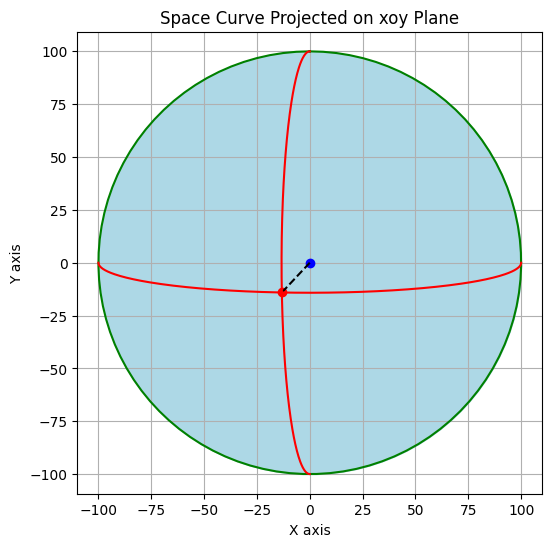

In [2]:
import numpy as np
import matplotlib.pyplot as plt

pitchyaw = datalist_group[0][0].pred_gaze


r = 100
theta_circle = np.linspace(0, 2 * np.pi, 100)
x_circle = r * np.sin(theta_circle)
y_circle = r * np.cos(theta_circle)


theta_new = pitchyaw[1]
phi_new = pitchyaw[0]

# 根据phi值计算y和z坐标
x = r * np.cos(phi_new) * np.sin(theta_new)
y = r * np.sin(phi_new)
z = r * np.cos(phi_new) * np.cos(theta_new)


# 根据真实坐标还原角度并投影
# 绘制竖圆
phi_1 = np.linspace(0, np.pi, 200)
proj_v = np.array([x,z])
x_axis = np.array([1, 0])
cos_theta_1 = np.dot(proj_v,x_axis) /(np.linalg.norm(proj_v) * np.linalg.norm(x_axis))
theta_1 = np.arccos(cos_theta_1)
x_1 = r * np.sin(phi_1) * np.cos(theta_1)
y_1 = r * np.cos(phi_1)

# 绘制横圆
phi_2 = np.linspace(0, np.pi, 200)
proj_y = np.array([y,z])
y_axis = np.array([1, 0])
cos_theta_2 = np.dot(proj_y,y_axis) /(np.linalg.norm(proj_y) * np.linalg.norm(y_axis))
theta_2 = np.arccos(cos_theta_2)
x_2 = r * np.cos(phi_2)
y_2 = r * np.sin(phi_2) * np.cos(theta_2)



# 绘制曲线在xoy平面的投影
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x,y,'ro')
ax.plot(0,0,'bo')
ax.plot([0, x], [0, y], 'k--')
ax.plot(x_circle, y_circle, 'g-')  # 绘制圆形投影
ax.fill_between(x_circle, y_circle, color='lightblue')
ax.plot(x_1, y_1, 'r-')  # 曲线路径
ax.plot(x_2, y_2, 'r-')  # 曲线路径
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_title('Space Curve Projected on xoy Plane')
ax.axis('equal')
ax.grid(True)

plt.show()